In [ ]:
'''
小鱼儿老师：课程15-DQN-捕食者游戏 https://www.bilibili.com/video/BV1nZ4y1X7bk/?p=3&spm_id_from=pageDriver&vd_source=eb79911dba31f65406585397357ca033
'''

In [1]:
import numpy as np
import cv2
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import time
import os
from matplotlib import style
style.use('ggplot')

In [2]:
# 方格类：可实例化为玩家、食物、敌人
class Cube:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, self.size)
        self.y = np.random.randint(0, self.size)
        
    def __str__(self):
        return f'{self.x},{self.y}'
    
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    
    def __eq__(self, other):
        return (self - other == (0, 0))

    # 1:向左或向下，2：不动，3：向右或向上
    def action(self, choise):
        if choise == 0:
            self.move(x=2, y=2)
        elif choise == 1:
            self.move(x=3, y=2)
        elif choise == 2:
            self.move(x=2, y=3)
        elif choise == 3:
            self.move(x=2, y=1)
        elif choise == 4:
            self.move(x=1, y=2)
        elif choise == 5:
            self.move(x=3, y=1)
        elif choise == 6:
            self.move(x=3, y=3)
        elif choise == 7:
            self.move(x=1, y=3)
        elif choise == 8:
            self.move(x=1, y=1)  
    
    def move(self, x=False, y=False):
        if not x:
            self.x = self.x + np.random.randint(-1, 2)
        else:
            self.x = self.x + x - 2
        if not y:
            self.y = self.y + np.random.randint(-1, 2) 
        else:
            self.y = self.y + y -2
               
        #边界情况
        if self.x < 0:
            self.x = 0
        if self.x >= self.size:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        if self.y >= self.size:
            self.y = self.size-1

In [3]:
# 环境类 
class envCube:
    SIZE = 10

    OBSERVATION_SPACE_VALUES = (4, ) #(2*SIZE-1, 2*SIZE-1, 2*SIZE-1, 2*SIZE-1) # 观测值空间
    ACTION_SPACE_VALUES = 9 # action操作数

    IMAGE_SHAPE = (SIZE, SIZE, 3) # 画面大小
    RETURN_IMAGE = False # 是否返回图像为observation

    FOOD_REWARD = 25 #食物奖励
    MOVE_PENALITY = -1 #移动惩罚
    ENEMY_PENALITY = -300 #敌人惩罚

    
    BGR = { 1:(255, 0, 0), # blue
            2:(0, 255, 0), # green
            3:(0, 0, 255)} # red
        
    PLAYER_N = 1
    FOOD_N = 2
    ENEMY_N = 3

    # 重置环境
    def reset(self):
        self.player = Cube(self.SIZE)
        self.food = Cube(self.SIZE)
        while (self.player == self.food):
            self.food = Cube(self.SIZE)

        self.enemy = Cube(self.SIZE)
        while (self.player == self.enemy or self.food == self.enemy):
            self.enemy = Cube(self.SIZE)
        
        if self.RETURN_IMAGE:
            observation = np.array(self.get_image())
        else:
            observation = (self.player - self.food) + (self.player - self.enemy)

        # 局数重置
        self.episode_step = 0

        return observation
    
    '''
    new_observation: 新状态
    reward: 当前步骤的奖励
    done: 游戏是否结束
    '''
    def step(self, action):
        self.episode_step += 1

        self.player.action(action)
        self.food.move()
        self.enemy.move()

        if self.RETURN_IMAGE:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player - self.food) + (self.player - self.enemy)

        if (self.player == self.food):
            reward = self.FOOD_REWARD
        elif (self.player == self.enemy):
            reward = self.ENEMY_PENALITY
        else:
            reward = self.MOVE_PENALITY
        
        done = False
        if (self.player == self.food or self.player == self.enemy or self.episode_step >= 200):
            done = True
        info = {'prob': 1.0}
        return new_observation, reward, done, info
    

    '''
    获取画图数组
    '''
    def get_image(self):
        env_image = np.zeros(self.IMAGE_SHAPE, dtype=np.uint8)
        env_image[self.food.x][self.food.y] = self.BGR[self.FOOD_N]
        env_image[self.player.x][self.player.y] = self.BGR[self.PLAYER_N]
        env_image[self.enemy.x][self.enemy.y] = self.BGR[self.ENEMY_N]
        image = Image.fromarray(env_image, 'RGB')
        return image

    '''
    画图
    '''
    def render(self, mode='human'):
        img = self.get_image()
        img = img.resize((800, 800))
        cv2.imshow('', np.array(img))
        cv2.waitKey(1)

    '''
    q_table
    '''
    def init_q_table(self, q_table_name=None):
        # 初始化Q——table
        if q_table_name is None:
            q_table = {}

            for x1 in range(-self.SIZE+1, self.SIZE):
                for y1 in range(-self.SIZE+1, self.SIZE):
                    for x2 in range(-self.SIZE+1, self.SIZE):
                        for y2 in range(-self.SIZE+1, self.SIZE):
                            q_table[x1, y1, x2, y2] = [np.random.uniform(-5, 0) for i in range(self.ACTION_SPACE_VALUES)]                        
        else:
            with open(q_table_name, 'rb') as f:
                q_table = pickle.load(f) 
        return q_table

episode #0, epsilon:0.6
episode #3000, epsilon:0.32926722239570905
mean reward:-180.657
episode #6000, epsilon:0.18069483957364205
mean reward:-157.46866666666668
episode #9000, epsilon:0.09916147987941909
mean reward:-129.065
episode #12000, epsilon:0.054417708414240505
mean reward:-111.47033333333333
episode #15000, epsilon:0.029863279497827713
mean reward:-98.514
episode #18000, epsilon:0.016388331819794114
mean reward:-90.45333333333333
episode #21000, epsilon:0.00899356749667138
mean reward:-83.074
episode #24000, epsilon:0.00493547831509555
mean reward:-78.41466666666666
episode #27000, epsilon:0.0027084853933429503
mean reward:-72.05366666666667
episode #30000, epsilon:0.0014863591039423116
mean reward:-68.44966666666667
episode #33000, epsilon:0.0008156822227294347
mean reward:-65.63766666666666
episode #36000, epsilon:0.00044762903305946587
mean reward:-68.509
episode #39000, epsilon:0.0002456492806319455
mean reward:-65.00266666666667
episode #42000, epsilon:0.000134807093861

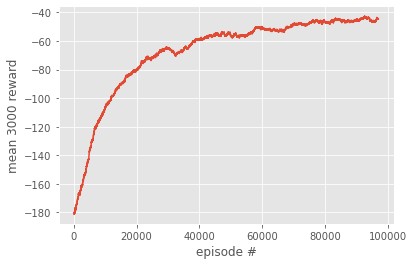

In [14]:
#train
'''
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()
'''
# 初始化环境参数
SIZE = 10
EPISODES = 100000
SHOW_EVERY = 3000

epsilon = 0.6 #选择随机概率
EPS_DECAY = 0.9998 #概率折扣

DISCOUNT = 0.95 #折扣 gamma
LEARNING_RATE = 0.3 #alpha

q_table_name = f'Q_table\qtable_1719578112.pickle'

env = envCube()
obs = env.reset()
q_table = env.init_q_table()

# train
episode_rewards = [] # 奖励序列
for episode in range(EPISODES): 
    done = False   

    # 显示图像 
    if(episode % SHOW_EVERY == 0):
        print(f'episode #{episode}, epsilon:{epsilon}')
        flag_show = False
        if(episode >= SHOW_EVERY):
            print(f'mean reward:{np.mean(episode_rewards[-SHOW_EVERY:])}')
            flag_show = True
    else:
        flag_show = False
    
    episode_reward = 0
    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs]) #选择Q值最高动作
        else:
            action = np.random.randint(0, env.ACTION_SPACE_VALUES) #随机选择一个动作
            
        newObs, reward, done, info = env.step(action)
    
        # Update the Q_table----------------------
        current_q = q_table[obs][action]    # 当前动作、状态对应Q_value
        max_future_q = np.max(q_table[obs]) # 新状态最大Q_value

        if (reward == env.FOOD_REWARD):
            new_q = env.FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT + max_future_q) 

        q_table[obs][action] = new_q
        obs = newObs
        # ---------------------------------
        
        if flag_show:
            env.render()
  
        episode_reward += reward
        
    if done:
        obs = env.reset()       
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY
    
cv2.destroyAllWindows()
#画曲线
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode = 'valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

if not os.path.exists('Q_table'):
    os.makedirs('Q_table')
with open(f'Q_table\qtable_pro_{int(time.time())}.pickle', 'wb') as f:
    pickle.dump(q_table, f)


In [4]:
def test(q_table, episodes, show_enable=True):
    env = envCube()
    
    obs = env.reset()
    operations = []
    rewards = []
    for episode in range(episodes):
        done = False
        operation = 0
        episode_reward = 0

        while not done:
            action = np.argmax(q_table[obs])
            newObs, reward, done, info = env.step(action)
            obs = newObs
            operation += 1
            episode_reward += reward

            if show_enable:
                env.render()
              
        if done:
            print(f'episode: #{episode} reward:{episode_reward}  The number of operation:{operation}')
            obs = env.reset()
            operations.append(operation)
            rewards.append(episode_reward)

        cv2.waitKey(5000)
        cv2.destroyAllWindows()

    print(f'mean operations:{np.mean(operations[:])} mean reward:{np.mean(rewards[:])}')
        


In [15]:
with open('Q_table\qtable_pro_1720684190.pickle', 'rb') as f:
    q_table_save = pickle.load(f)
test(q_table_save, 20)

episode: #0 reward:-40  The number of operation:66
episode: #1 reward:-27  The number of operation:53
episode: #2 reward:-12  The number of operation:38
episode: #3 reward:-92  The number of operation:118
episode: #4 reward:3  The number of operation:23
episode: #5 reward:20  The number of operation:6
episode: #6 reward:21  The number of operation:5
episode: #7 reward:-9  The number of operation:35
episode: #8 reward:-31  The number of operation:57
episode: #9 reward:18  The number of operation:8
episode: #10 reward:-93  The number of operation:119
episode: #11 reward:20  The number of operation:6
episode: #12 reward:5  The number of operation:21
episode: #13 reward:-6  The number of operation:32
episode: #14 reward:-348  The number of operation:49
episode: #15 reward:-7  The number of operation:33
episode: #16 reward:23  The number of operation:3
episode: #17 reward:7  The number of operation:19
episode: #18 reward:18  The number of operation:8
episode: #19 reward:-132  The number of 

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

Using TensorFlow backend.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [13]:
def build_model(status, nb_actions): 
    # Next, we build a very simple model.
    model = Sequential()
    model.add(Flatten(input_shape=(2,) + status)) # status: env.observation_space.shape
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # 输出层
    model.add(Dense(nb_actions, activation='linear')) # nb_actions: env.action_space.n
    return model


In [14]:
def build_agent(model, nb_actions):
    # Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
    # even the metrics!
    memory = SequentialMemory(limit=50000, window_length=2) # window_length 窗口值，应该与model输入层的（1,)对应，即输入样本数对应
    policy = BoltzmannQPolicy() # 玻尔兹曼策略
    dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=1000, 
                   target_model_update=1e-2, policy=policy)
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])
    return dqn

In [15]:
env = envCube()
model = build_model(env.OBSERVATION_SPACE_VALUES, env.ACTION_SPACE_VALUES)
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 297       
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
dqn = build_agent(model, env.ACTION_SPACE_VALUES)

In [17]:
dqn.fit(env, nb_steps=100000, visualize=True, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
 1001/10000 [==>...........................] - ETA: 4:07 - reward: -1.7403

AttributeError: Tensor.op is meaningless when eager execution is enabled.

In [ ]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_n1_weights.h5f', overwrite=True)

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
scores = dqn.test(env, nb_episodes=10, visualize=True)
print(np.mean(scores.history['episode_reward']))

In [ ]:
# 删除已生成的
del dqn, model

# 从新实例化一个dqn和model

In [ ]:
# 加载参数
dqn.load_weights('dqn_n1_weights.h5f')


In [11]:
cv2.destroyAllWindows()